In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt


from sklearn import linear_model
from skimage.feature import peak_local_max

truncate_circle = False

/home/s/Sunny.Howard/anaconda3/envs/torchenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

In [23]:
ref = plt.imread('/project/agdoepp/Experiment/Overcomplete_Dictionary/reference06_11.png')
data = plt.imread('/project/agdoepp/Experiment/Overcomplete_Dictionary/06_11VORTEX_z6.png')
# data = plt.imread('/project/agdoepp/Experiment/Overcomplete_Dictionary/06_11VORTEX.png')


ref = ref.sum(axis=2)
data = data.sum(axis=2)

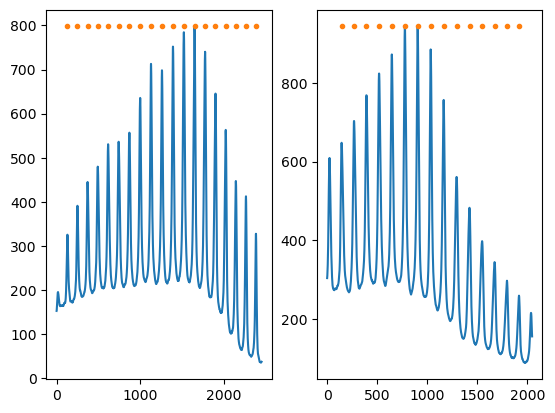

In [24]:
int_ref_x = np.sum(ref,axis=0)
int_ref_y = np.sum(ref,axis=1)

peaks_intx = peak_local_max(int_ref_x, min_distance=40,threshold_abs=0.05)[:,0]

peaks_inty = peak_local_max(int_ref_y, min_distance=40,threshold_abs=0.05)[:,0]

fig,ax = plt.subplots(1,2,dpi=100)

ax[0].plot(int_ref_x)
ax[0].plot(peaks_intx, np.ones_like(peaks_intx)*int_ref_x.max(),'.')

ax[1].plot(int_ref_y)
ax[1].plot(peaks_inty, np.ones_like(peaks_inty)*int_ref_y.max(),'.')


In [25]:
dx = np.diff(np.sort(peaks_intx))
dy = np.diff(np.sort(peaks_inty))
print(f'mean difference X: {dx.mean():.3g}pm{dx.std():.1g}, mean difference Y:  {dy.mean():.3g}pm{dy.std():.1g}')

mean difference X: 125pm4, mean difference Y:  127pm3


In [26]:
edge = [0,ref.shape[1],0,ref.shape[0]] #here we can specify the edges of where the grid should be. 

grid_spotsx = np.sort(peaks_intx) + dx.mean()//2
grid_spotsy = np.sort(peaks_inty) + dy.mean()//2

#lets fill in the grid at the end and start. 



while grid_spotsx[0] > edge[0] + dx.mean():
    grid_spotsx = np.insert(grid_spotsx,0,grid_spotsx[0]-dx.mean())
while grid_spotsx[-1] < edge[1] - dx.mean():
    grid_spotsx = np.append(grid_spotsx,grid_spotsx[-1]+dx.mean())

while grid_spotsy[0] > edge[2] + dy.mean():
    grid_spotsy = np.insert(grid_spotsy,0,grid_spotsy[0]-dy.mean())
while grid_spotsy[-1] < edge[3] - dy.mean():
    grid_spotsy = np.append(grid_spotsy,grid_spotsy[-1]+dy.mean())
    

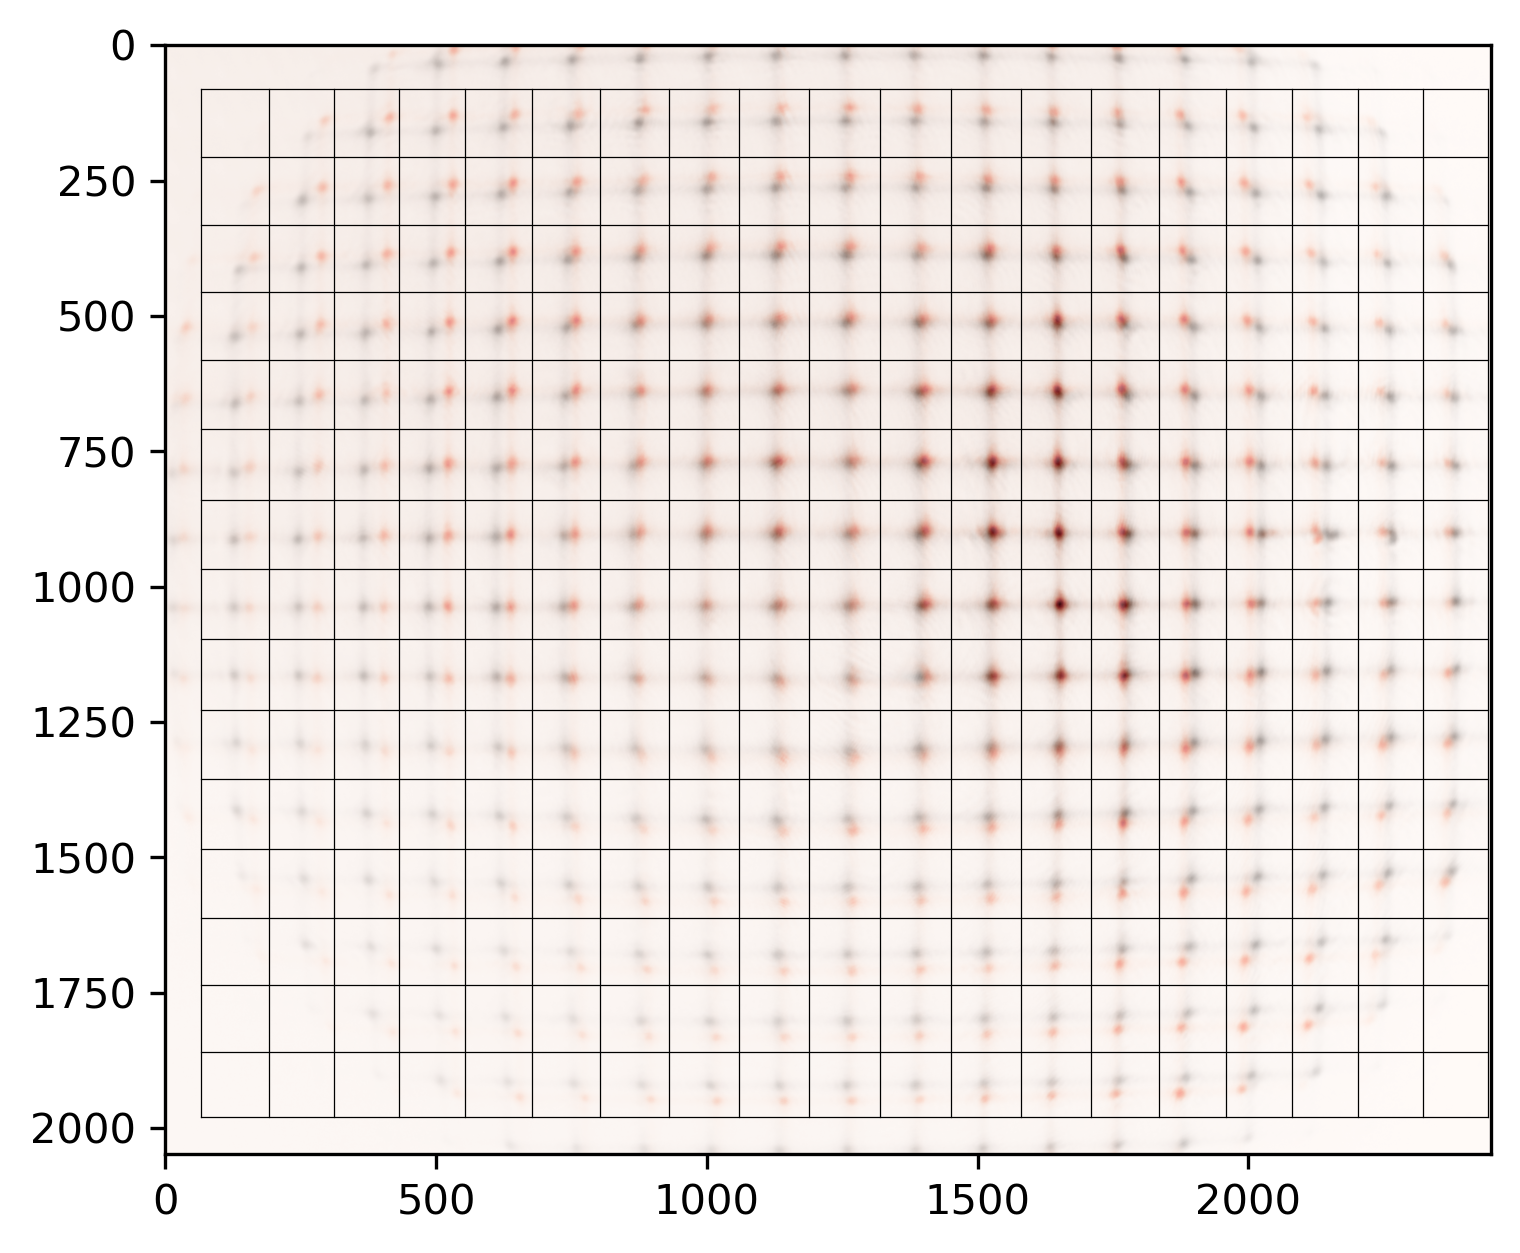

In [27]:
#plot the grid?

fig,ax = plt.subplots(1,1,dpi=300)
ax.imshow(ref,cmap='gray_r')
ax.imshow(data,cmap='Reds',alpha=0.5)

for i in range(grid_spotsx.shape[0]):
    ax.plot(np.ones_like(grid_spotsy)*grid_spotsx[i],grid_spotsy,'k',linewidth=0.3)

for i in range(grid_spotsy.shape[0]):
    ax.plot(grid_spotsx,np.ones_like(grid_spotsx)*grid_spotsy[i],'k',linewidth=0.3)

    

In [28]:
from scipy.ndimage import center_of_mass

pad = 30

centers_of_mass_ref = np.zeros((len(grid_spotsy)-1,len(grid_spotsx)-1,2))
centers_of_mass_data = np.zeros((len(grid_spotsy)-1,len(grid_spotsx)-1,2))
for i in range(len(grid_spotsy)-1):
    for j in range(len(grid_spotsx)-1):
        x1, x2 = int(grid_spotsx[j]), int(grid_spotsx[j+1])
        y1, y2 = int(grid_spotsy[i]), int(grid_spotsy[i+1])
        
        section = ref[y1:y2, x1:x2]
        bla_x,bla_y = np.where(section == section.max())
        bla = (bla_y[0],bla_x[0])
        mask = np.zeros_like(section)
        mask[bla[0] - pad:bla[0] + pad, bla[1] - pad:bla[1] + pad] = 1
        section*=mask
        com = center_of_mass(section)
        centers_of_mass_ref[i,j] = (com[1]+x1, com[0]+y1)

        section = data[y1:y2, x1:x2]
        bla_x,bla_y = np.where(section == section.max())
        bla = (bla_y[0],bla_x[0])
        mask = np.zeros_like(section)
        mask[bla[0] - pad:bla[0] + pad, bla[1] - pad:bla[1] + pad] = 1
        section*=mask
        com = center_of_mass(section)
        centers_of_mass_data[i,j] = (com[1]+x1, com[0]+y1)


diffs = centers_of_mass_data - centers_of_mass_ref

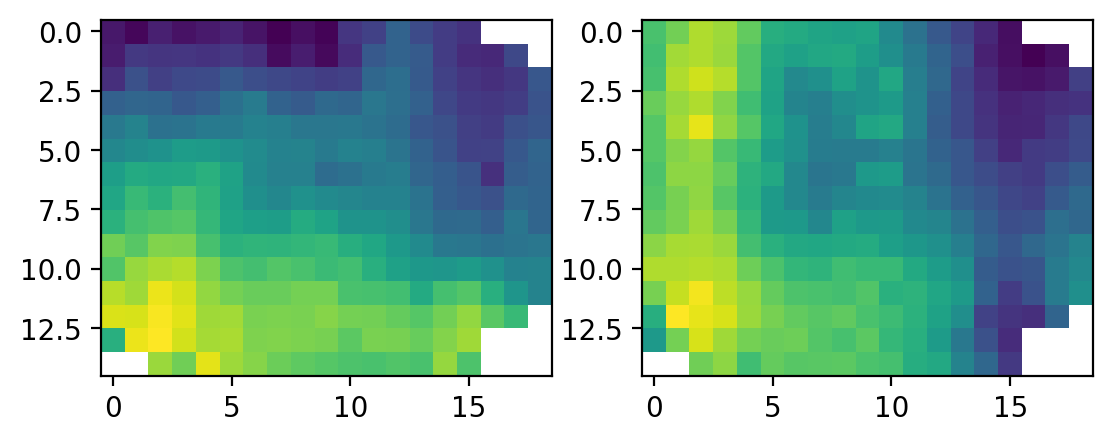

In [29]:
fig,ax = plt.subplots(1,2,dpi=200)
ax[0].imshow(diffs[...,0])
ax[1].imshow(diffs[...,1])

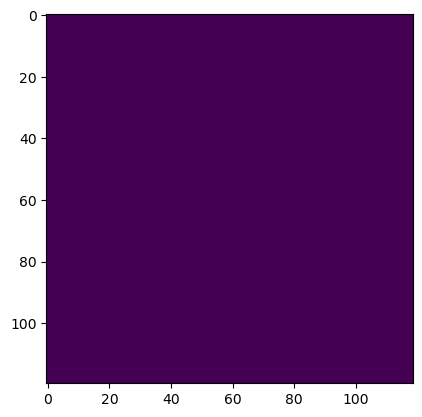

In [43]:
plt.imshow(section)

## Lets find CoM differences

In [21]:
spot_displacements = np.zeros_like(reordered_peaks_data,dtype=np.float32)

In [22]:
pad = 40

for i in range(len(reordered_peaks_data)):
    data_com = reordered_peaks_data[i] + np.array(center_of_mass(data[reordered_peaks_data[i,0]-pad:reordered_peaks_data[i,0]+pad,reordered_peaks_data[i,1]-pad:reordered_peaks_data[i,1]+pad]))
    ref_com = peaks_ref[i] + np.array(center_of_mass(ref[peaks_ref[i,0]-pad:peaks_ref[i,0]+pad,peaks_ref[i,1]-pad:peaks_ref[i,1]+pad]))

    spot_displacements[i] = data_com - ref_com

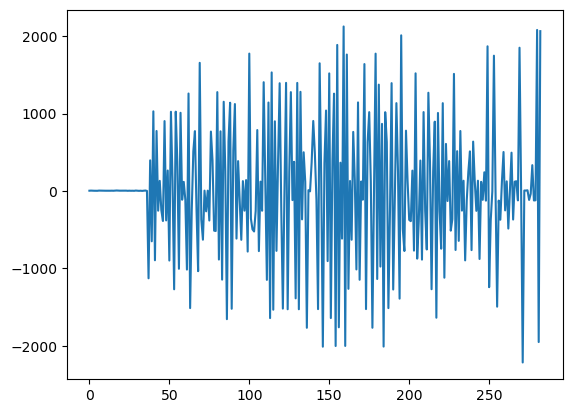

In [23]:
plt.plot(spot_displacements[:,1])

Text(0.5, 1.0, 'y displacement')

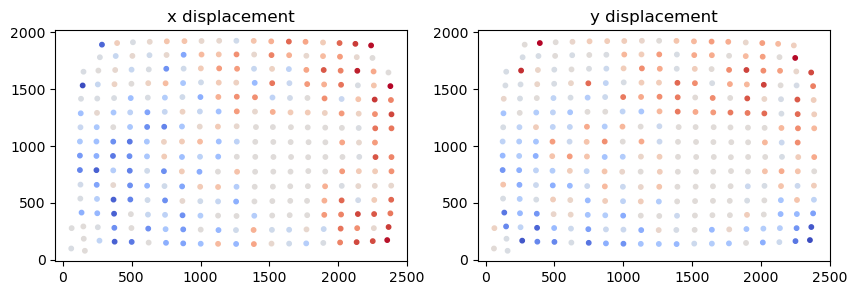

In [24]:
fig,ax = plt.subplots(1,2,dpi=100, figsize=(10,3))
ax[0].scatter(reordered_peaks_data[:,1],reordered_peaks_data[:,0], c=spot_displacements[:,1],cmap='coolwarm',s=10); ax[0].set_title('x displacement')
ax[1].scatter(reordered_peaks_data[:,1],reordered_peaks_data[:,0], c=spot_displacements[:,0],cmap='coolwarm',s=10); ax[1].set_title('y displacement')

In [26]:
f = 14.6e-3
pixelsize = 3.45e-6

wavefront_grad = spot_displacements * pixelsize / f

In [27]:
wavefront_grad

array([[-1.44887585e-04,  7.69045611e-04],
       [ 1.80053976e-04,  1.09751883e-03],
       [ 1.23644786e-04,  7.61406438e-04],
       [ 2.74382419e-05,  6.28768757e-04],
       [-2.67170515e-04,  5.42552210e-04],
       [-9.60232501e-05,  5.04351745e-04],
       [-7.03907790e-05,  1.14048424e-03],
       [ 6.01314532e-04,  1.11723831e-03],
       [-2.11576989e-04,  8.05099960e-04],
       [-3.48805508e-04,  8.28127319e-04],
       [ 4.22114317e-06,  7.10152672e-04],
       [ 4.82425785e-05,  6.59409619e-04],
       [-2.89792632e-04,  8.50356708e-04],
       [ 2.58251792e-04,  6.79257035e-04],
       [-5.16519867e-05,  8.46660056e-04],
       [ 6.72649112e-05,  6.31549978e-04],
       [-4.85405908e-05,  9.28444439e-04],
       [ 1.59512419e-04,  1.41680485e-03],
       [-3.19979765e-04,  1.07173808e-03],
       [ 2.00829745e-04,  8.40891094e-04],
       [-4.74577100e-04,  8.97710677e-04],
       [ 4.81537194e-04,  1.16128533e-03],
       [ 6.43581807e-05,  9.78476950e-04],
       [-1.